##### Objective:
   * To identify fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#####  About The Data:
   * The datasets contains transactions made by credit cards in September 2013.These transactions occured in two days, and there are 429 frauds out of 284,807 transactions. 
   * PCA (Principal Component Analysis)- an unsupervised, non-parametric statistical technique is used for dimensionality reduction in machine learning. Features from v1 - v28 are the results of this PCA 
   * Other features (except 'Time' and 'Amount') are changed to protect the privacy of the customers.
   * Feature 'Time' is the time elapsed between each transaction and the first transaction
   * Feature 'Amount' depicts the amount of each transaction
   * Feature 'Class' is the dependent variable/target variable. 1 means fraudulent, and 0 means genuine.

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# Load and display the first 5 rows of the creditcard transactions file
df = pd.read_csv('creditcard_transactions.csv')
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [3]:
# Remove the column "Unnamed: 0" because we don't need it
df.drop(columns = 'Unnamed: 0', inplace =True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,-0.715756,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,0.984938,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [4]:
# Calculate statistical data such as mean, std, min, percentiles using .describe() method
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,95357.290375,0.016628,-0.005726,-0.010398,-0.028731,-0.022065,0.000739,0.016121,-0.004941,-0.013924,...,-0.003501,0.028278,0.006422,-0.000855,-0.000284,0.000740,-0.006161,0.005893,89.669246,0.002125
std,46956.240862,1.899212,1.545809,1.477050,1.426184,1.401964,1.332905,1.305012,1.174568,1.106161,...,0.678019,0.714746,0.553929,0.606846,0.513374,0.485101,0.394584,0.348770,260.188804,0.046052
min,64.000000,-29.973363,-29.198899,-19.947726,-5.416315,-40.427726,-7.810116,-21.234463,-26.069936,-8.739670,...,-13.950186,-4.910197,-12.667179,-2.814898,-3.223535,-1.511259,-5.809357,-3.693525,0.000000,0.000000
25%,55189.750000,-0.915243,-0.610001,-0.893566,-0.903137,-0.714806,-0.790640,-0.560447,-0.215935,-0.653245,...,-0.221765,-0.519427,-0.159989,-0.345288,-0.311490,-0.327823,-0.071358,-0.052957,5.990000,0.000000
50%,85758.000000,0.025737,0.040064,0.165369,-0.035525,-0.076317,-0.282476,0.043119,0.019278,-0.057401,...,-0.026597,0.031274,-0.008716,0.038126,0.023790,-0.061720,0.000514,0.011239,22.855000,0.000000
75%,139042.750000,1.321858,0.784179,0.991859,0.752604,0.601602,0.403259,0.581711,0.331131,0.594168,...,0.191495,0.549468,0.144751,0.440633,0.344371,0.246298,0.086333,0.076835,78.432500,0.000000
max,172766.000000,2.373022,11.447082,3.985446,9.074932,13.815072,23.917837,44.054461,9.561121,7.938980,...,14.507345,4.222704,19.228169,3.577753,2.520869,2.693658,5.352193,15.649134,10199.440000,1.000000


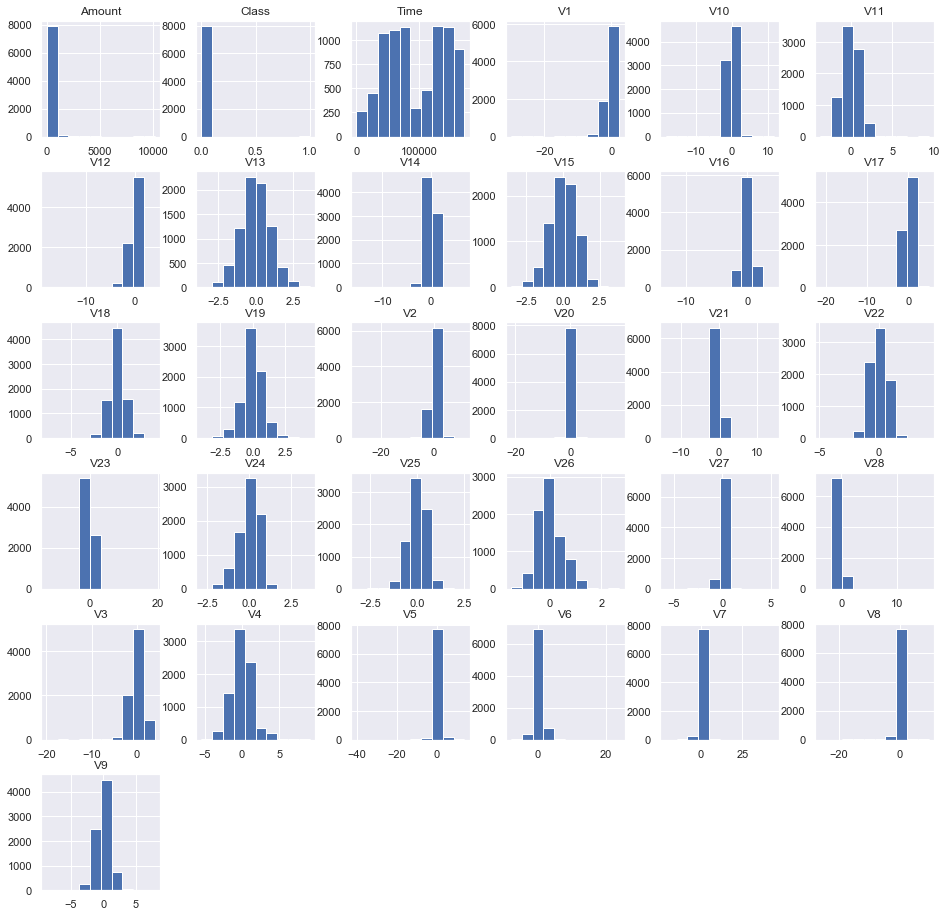

In [55]:
# Plot data distribution for each feature in the dataset
df.hist(figsize=(16,16))
plt.show()

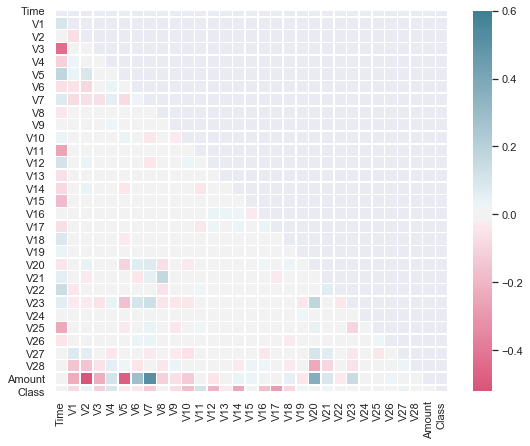

In [48]:
# create the correlation heatmap
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axs = plt.subplots(figsize=(9, 7))

cmap = sns.diverging_palette(1,222, as_cmap=True)

sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.6,
            center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": 1});

##### Notes:
* None of the V1 to V28 has any correlation to each other
* 'Class' don't have any correlation with 'Amount' or 'Time', but it does have some form of positive and negative correlations with the 'V' components
* 'Amount' does have some positive and negative correlations with the 'V' components

In [30]:
# Check for number of frauds vs number of normal transactions 
df_class = df['Class'].value_counts()
df_class
print(f"The number of Valid Transactions is: {df_class[0]}")
print(f"The number of Fraud Transactions is: {df_class[1]}")

The number of Valid Transactions is: 7983
The number of Fraud Transactions is: 17


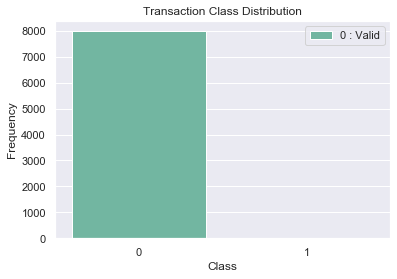

In [31]:
# use bar plot to visualize the higly unbalance in "Class" feature
ax = sns.countplot(x="Class",data=df, palette="Set2")
plt.title('Transaction Class Distribution')
plt.ylabel('Frequency')
plt.legend(['0 : Valid','1: Fraud'])

##### Notes:
* There are 17 fraud transactions out of 8000 transactions during 2 consecutive days in September.
* This highly unbalance with respect to target variable 'Class' needs to be treated before any further data processing.